In [1]:
import warnings                           
warnings.filterwarnings('ignore')

import datetime
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot

from itertools import product
from tqdm import tqdm_notebook

%matplotlib inline

from utils import mean_absolute_percentage_error, timeseries_train_test_split, train_test_split, time_lags_generation, compute_model_error, optimal_leg_search_1d

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV, RidgeCV

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [2]:
data = pd.read_excel('./data/top-9-zurrahmat.xlsx', skiprows= 4, usecols= [0,1], names = ['date', 'meals'])
print(data.shape)
data.head()

(48, 2)


,date,meals
0,2020-09-14 00:00:00,74.0
1,2020-09-15 00:00:00,52.0
2,2020-09-16 00:00:00,60.0
3,2020-09-17 00:00:00,63.5
4,2020-09-18 00:00:00,82.0


In [3]:
data.tail()

,date,meals
43,2020-10-27 00:00:00,60.5
44,2020-10-28 00:00:00,67.0
45,2020-10-29 00:00:00,1.0
46,2020-10-30 00:00:00,61.5
47,Итого,2972.0


In [4]:
# remove the last row
data = data.iloc[:-1]

In [5]:
data.tail()

,date,meals
42,2020-10-26 00:00:00,47.0
43,2020-10-27 00:00:00,60.5
44,2020-10-28 00:00:00,67.0
45,2020-10-29 00:00:00,1.0
46,2020-10-30 00:00:00,61.5


In [6]:
data['date'] = pd.to_datetime(data['date'])
post_covid_df = data.copy()
post_covid_df.head()

,date,meals
0,2020-09-14,74.0
1,2020-09-15,52.0
2,2020-09-16,60.0
3,2020-09-17,63.5
4,2020-09-18,82.0


In [7]:
post_covid_df.tail(10)

,date,meals
37,2020-10-21,64.5
38,2020-10-22,54.0
39,2020-10-23,71.5
40,2020-10-24,80.5
41,2020-10-25,58.0
42,2020-10-26,47.0
43,2020-10-27,60.5
44,2020-10-28,67.0
45,2020-10-29,1.0
46,2020-10-30,61.5


In [8]:
post_covid_df_time = post_covid_df.set_index('date')

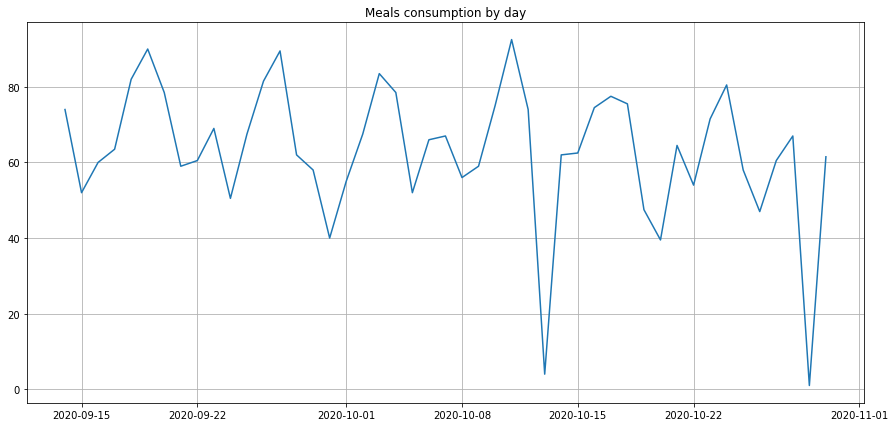

In [9]:
plt.figure(figsize=(15,7))
plt.plot(post_covid_df_time)
plt.title('Meals consumption by day')
plt.grid(True)
plt.show()

In [10]:
# extract the last datepoint of the currect dataframe
latest_entry = post_covid_df.iloc[-1]
latest_datetime = latest_entry['date']

In [11]:
# define the number of days interval to forecast
days_forecast = 7
forecast_date = latest_datetime + datetime.timedelta(days=days_forecast)

# generate a new df for forecast
date_rng = pd.date_range(start=latest_datetime + datetime.timedelta(days=1), end=forecast_date, freq='D')
forecast_df = pd.DataFrame(date_rng, columns=['date'])
forecast_df.head(8)

,date
0,2020-10-31
1,2020-11-01
2,2020-11-02
3,2020-11-03
4,2020-11-04
5,2020-11-05
6,2020-11-06


In [12]:
#concatenate these two df
frames = [post_covid_df, forecast_df]
result_df = pd.concat(frames)
result_df.tail(20)

,date,meals
34,2020-10-18,75.5
35,2020-10-19,47.5
36,2020-10-20,39.5
37,2020-10-21,64.5
38,2020-10-22,54.0
39,2020-10-23,71.5
40,2020-10-24,80.5
41,2020-10-25,58.0
42,2020-10-26,47.0
43,2020-10-27,60.5


In [13]:
result_df = result_df.set_index('date')
result_df.head(10)

,meals
date,
2020-09-14,74.0
2020-09-15,52.0
2020-09-16,60.0
2020-09-17,63.5
2020-09-18,82.0
2020-09-19,90.0
2020-09-20,78.5
2020-09-21,59.0
2020-09-22,60.5


In [14]:
print(result_df.shape)

(54, 1)


In [15]:
result_df = pd.DataFrame(result_df.meals.copy())
result_df.columns = ["target"]

In [16]:
# Adding the lag of the target varable from 7 steps back (week) up to 30 (month)
lag_start = 7
lag_end = 22
result_df = time_lags_generation(result_df, start=lag_start, end=lag_end)
result_df.head(25)

,target,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
date,,,,,,,,,,,,,,,,
2020-09-14,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-15,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-16,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-17,63.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-18,82.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-19,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-20,78.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-21,59.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-22,60.5,52.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
result_df.shape

(54, 16)

In [18]:
result_df = result_df[lag_end-1:]
print(result_df.shape)
result_df.head(20)

(33, 16)


,target,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
date,,,,,,,,,,,,,,,,
2020-10-05,52.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0,78.5,90.0,82.0,63.5,60.0,52.0,74.0
2020-10-06,66.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0,78.5,90.0,82.0,63.5,60.0,52.0
2020-10-07,67.0,40.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0,78.5,90.0,82.0,63.5,60.0
2020-10-08,56.0,55.0,40.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0,78.5,90.0,82.0,63.5
2020-10-09,59.0,67.5,55.0,40.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0,78.5,90.0,82.0
2020-10-10,75.0,83.5,67.5,55.0,40.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0,78.5,90.0
2020-10-11,92.5,78.5,83.5,67.5,55.0,40.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0,78.5
2020-10-12,74.0,52.0,78.5,83.5,67.5,55.0,40.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0
2020-10-13,4.0,66.0,52.0,78.5,83.5,67.5,55.0,40.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5


In [19]:
result_df.tail(25)

,target,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
date,,,,,,,,,,,,,,,,
2020-10-13,4.0,66.0,52.0,78.5,83.5,67.5,55.0,40.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5
2020-10-14,62.0,67.0,66.0,52.0,78.5,83.5,67.5,55.0,40.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0
2020-10-15,62.5,56.0,67.0,66.0,52.0,78.5,83.5,67.5,55.0,40.0,58.0,62.0,89.5,81.5,67.5,50.5
2020-10-16,74.5,59.0,56.0,67.0,66.0,52.0,78.5,83.5,67.5,55.0,40.0,58.0,62.0,89.5,81.5,67.5
2020-10-17,77.5,75.0,59.0,56.0,67.0,66.0,52.0,78.5,83.5,67.5,55.0,40.0,58.0,62.0,89.5,81.5
2020-10-18,75.5,92.5,75.0,59.0,56.0,67.0,66.0,52.0,78.5,83.5,67.5,55.0,40.0,58.0,62.0,89.5
2020-10-19,47.5,74.0,92.5,75.0,59.0,56.0,67.0,66.0,52.0,78.5,83.5,67.5,55.0,40.0,58.0,62.0
2020-10-20,39.5,4.0,74.0,92.5,75.0,59.0,56.0,67.0,66.0,52.0,78.5,83.5,67.5,55.0,40.0,58.0
2020-10-21,64.5,62.0,4.0,74.0,92.5,75.0,59.0,56.0,67.0,66.0,52.0,78.5,83.5,67.5,55.0,40.0


In [20]:
# use 'n_train' samples for training and the rest for testing

train_df = result_df[:-days_forecast]
print(train_df.shape)
train_df.head(10)

(26, 16)


,target,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
date,,,,,,,,,,,,,,,,
2020-10-05,52.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0,78.5,90.0,82.0,63.5,60.0,52.0,74.0
2020-10-06,66.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0,78.5,90.0,82.0,63.5,60.0,52.0
2020-10-07,67.0,40.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0,78.5,90.0,82.0,63.5,60.0
2020-10-08,56.0,55.0,40.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0,78.5,90.0,82.0,63.5
2020-10-09,59.0,67.5,55.0,40.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0,78.5,90.0,82.0
2020-10-10,75.0,83.5,67.5,55.0,40.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0,78.5,90.0
2020-10-11,92.5,78.5,83.5,67.5,55.0,40.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0,78.5
2020-10-12,74.0,52.0,78.5,83.5,67.5,55.0,40.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0
2020-10-13,4.0,66.0,52.0,78.5,83.5,67.5,55.0,40.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5


In [21]:
predict_df = result_df[-days_forecast:]
print(predict_df.shape)
predict_df.head(10)

(7, 16)


,target,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
date,,,,,,,,,,,,,,,,
2020-10-31,NaN,80.5,71.5,54.0,64.5,39.5,47.5,75.5,77.5,74.5,62.5,62.0,4.0,74.0,92.5,75.0
2020-11-01,NaN,58.0,80.5,71.5,54.0,64.5,39.5,47.5,75.5,77.5,74.5,62.5,62.0,4.0,74.0,92.5
2020-11-02,NaN,47.0,58.0,80.5,71.5,54.0,64.5,39.5,47.5,75.5,77.5,74.5,62.5,62.0,4.0,74.0
2020-11-03,NaN,60.5,47.0,58.0,80.5,71.5,54.0,64.5,39.5,47.5,75.5,77.5,74.5,62.5,62.0,4.0
2020-11-04,NaN,67.0,60.5,47.0,58.0,80.5,71.5,54.0,64.5,39.5,47.5,75.5,77.5,74.5,62.5,62.0
2020-11-05,NaN,1.0,67.0,60.5,47.0,58.0,80.5,71.5,54.0,64.5,39.5,47.5,75.5,77.5,74.5,62.5
2020-11-06,NaN,61.5,1.0,67.0,60.5,47.0,58.0,80.5,71.5,54.0,64.5,39.5,47.5,75.5,77.5,74.5


In [22]:
target = train_df.target
train_df = train_df.drop(['target'], axis=1)
train_df.head()

,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
date,,,,,,,,,,,,,,,
2020-10-05,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0,78.5,90.0,82.0,63.5,60.0,52.0,74.0
2020-10-06,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0,78.5,90.0,82.0,63.5,60.0,52.0
2020-10-07,40.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0,78.5,90.0,82.0,63.5,60.0
2020-10-08,55.0,40.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0,78.5,90.0,82.0,63.5
2020-10-09,67.5,55.0,40.0,58.0,62.0,89.5,81.5,67.5,50.5,69.0,60.5,59.0,78.5,90.0,82.0


In [23]:
predict_df = predict_df.drop(['target'], axis=1)
predict_df.head(10)

,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
date,,,,,,,,,,,,,,,
2020-10-31,80.5,71.5,54.0,64.5,39.5,47.5,75.5,77.5,74.5,62.5,62.0,4.0,74.0,92.5,75.0
2020-11-01,58.0,80.5,71.5,54.0,64.5,39.5,47.5,75.5,77.5,74.5,62.5,62.0,4.0,74.0,92.5
2020-11-02,47.0,58.0,80.5,71.5,54.0,64.5,39.5,47.5,75.5,77.5,74.5,62.5,62.0,4.0,74.0
2020-11-03,60.5,47.0,58.0,80.5,71.5,54.0,64.5,39.5,47.5,75.5,77.5,74.5,62.5,62.0,4.0
2020-11-04,67.0,60.5,47.0,58.0,80.5,71.5,54.0,64.5,39.5,47.5,75.5,77.5,74.5,62.5,62.0
2020-11-05,1.0,67.0,60.5,47.0,58.0,80.5,71.5,54.0,64.5,39.5,47.5,75.5,77.5,74.5,62.5
2020-11-06,61.5,1.0,67.0,60.5,47.0,58.0,80.5,71.5,54.0,64.5,39.5,47.5,75.5,77.5,74.5


In [24]:
lasso = LassoCV()
lasso.fit(train_df, target)
prediction = lasso.predict(predict_df)
print(prediction)

[59.61538462 59.61538462 59.61538462 59.61538462 59.61538462 59.61538462
 59.61538462]


In [25]:
prediction = [round(x) for x in prediction]
print(prediction)

[60, 60, 60, 60, 60, 60, 60]


Print prediction

In [26]:
prediction_df = pd.DataFrame(prediction, columns= ['meals'])
result_df = pd.concat([forecast_df, prediction_df], axis=1)
result_df.head(10)

,date,meals
0,2020-10-31,60
1,2020-11-01,60
2,2020-11-02,60
3,2020-11-03,60
4,2020-11-04,60
5,2020-11-05,60
6,2020-11-06,60


In [27]:
print(post_covid_df.shape, result_df.shape)

(47, 2) (7, 2)


In [28]:
combined_df = pd.concat([post_covid_df, result_df])
combined_df.tail(15)

,date,meals
39,2020-10-23,71.5
40,2020-10-24,80.5
41,2020-10-25,58.0
42,2020-10-26,47.0
43,2020-10-27,60.5
44,2020-10-28,67.0
45,2020-10-29,1.0
46,2020-10-30,61.5
0,2020-10-31,60.0
1,2020-11-01,60.0


In [29]:
combined_df = combined_df.set_index('date')

In [30]:
combined_df = combined_df.rename(columns = {'meals' : 'pred'})

In [31]:
post_covid_df_time

,meals
date,
2020-09-14,74.0
2020-09-15,52.0
2020-09-16,60.0
2020-09-17,63.5
2020-09-18,82.0
2020-09-19,90.0
2020-09-20,78.5
2020-09-21,59.0
2020-09-22,60.5


In [32]:
prediction_df_2d = pd.DataFrame(prediction, columns= ['meals_prediction'])

combined_2d = pd.concat([combined_df, post_covid_df_time], axis=1)
combined_2d.reset_index()

,date,pred,meals
0,2020-09-14,74.0,74.0
1,2020-09-15,52.0,52.0
2,2020-09-16,60.0,60.0
3,2020-09-17,63.5,63.5
4,2020-09-18,82.0,82.0
5,2020-09-19,90.0,90.0
6,2020-09-20,78.5,78.5
7,2020-09-21,59.0,59.0
8,2020-09-22,60.5,60.5
9,2020-09-23,69.0,69.0


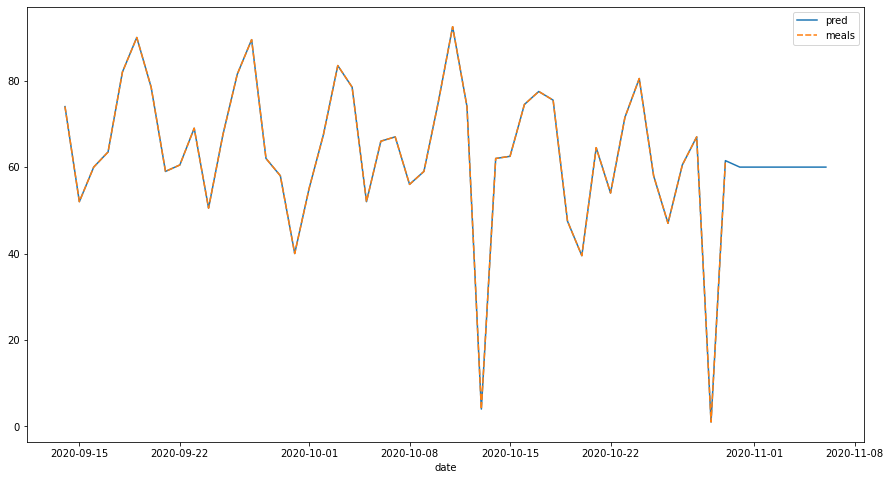

In [33]:
plt.figure(figsize=(15,8))
sns.lineplot(data=combined_2d)

In [34]:
time_data = pd.DataFrame(post_covid_df.meals.copy())
time_data.columns = ["target"]

In [35]:
result_dict = {}
lag_range = list(range(6,25))
start_lag = 1
lr = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
lasso = LassoCV(cv=tscv)

In [36]:
lasso_dict_errors = optimal_leg_search_1d(start_lag, lag_range, time_data, lasso)
sorted_dict_lasso = sorted(lasso_dict_errors.items(), key=lambda kv: kv[1])
sorted_dict_lasso

[((1, 8), 19.004593036124962),
 ((1, 7), 20.87599177691938),
 ((1, 6), 21.280770575360357),
 ((1, 14), 21.70131835970831),
 ((1, 9), 22.585913092871344),
 ((1, 10), 22.661764705882355),
 ((1, 24), 23.17258883248731),
 ((1, 23), 23.180304471931496),
 ((1, 22), 23.25475974614687),
 ((1, 17), 23.362415680621638),
 ((1, 16), 23.51489269866875),
 ((1, 15), 23.83616132372564),
 ((1, 12), 27.236271764880726),
 ((1, 11), 27.580254426689915),
 ((1, 13), 29.063279762766815),
 ((1, 20), 35.976459590244204),
 ((1, 21), 40.86853457744928),
 ((1, 18), 41.333917139664614),
 ((1, 19), 42.24602627478002)]

In [37]:
time_data = pd.DataFrame(post_covid_df.meals.copy())
time_data.columns = ["target"]
time_data.shape

(47, 1)

In [38]:
result_dict = {}
lag_range = list(range(7,28))
start_lag = list(range(1,6))

for i in start_lag:
    time_data = pd.DataFrame(post_covid_df.meals.copy())
    time_data.columns = ["target"]
    for j in lag_range:

        key = (i, j)
        df = time_lags_generation(time_data, i, j)
        x_train, x_test, y_train, y_test = train_test_split(df)
        tscv = TimeSeriesSplit(n_splits=5)
        lasso = LassoCV(cv=tscv)
        lasso.fit(x_train, y_train)
        prediction = lasso.predict(x_test)
        error = mean_absolute_percentage_error(prediction, y_test)

        result_dict[key] = error

In [39]:
sorted_dict = sorted(result_dict.items(), key=lambda kv: kv[1])
sorted_dict

[((2, 8), 19.004592872346016),
 ((1, 8), 19.004593036124962),
 ((4, 8), 19.549025062683643),
 ((5, 8), 19.549025062683643),
 ((3, 8), 20.36652220450499),
 ((1, 7), 20.87599177691938),
 ((2, 7), 20.87599177691938),
 ((3, 7), 21.069569001656703),
 ((3, 14), 21.612008435628017),
 ((1, 14), 21.70131835970831),
 ((2, 14), 21.70131835970831),
 ((4, 14), 21.90054705267687),
 ((5, 14), 21.90054705267687),
 ((4, 7), 22.034399071436106),
 ((5, 7), 22.034399071436106),
 ((4, 13), 22.105385802918644),
 ((5, 13), 22.105385802918644),
 ((1, 9), 22.585913092871344),
 ((2, 9), 22.585913092871344),
 ((1, 10), 22.661764705882355),
 ((2, 10), 22.661764705882355),
 ((4, 10), 22.661764705882355),
 ((5, 10), 22.661764705882355),
 ((1, 24), 23.17258883248731),
 ((2, 24), 23.17258883248731),
 ((1, 23), 23.180304471931496),
 ((2, 23), 23.180304471931496),
 ((1, 22), 23.25475974614687),
 ((2, 22), 23.25475974614687),
 ((1, 17), 23.362415680621638),
 ((2, 17), 23.362415680621638),
 ((4, 12), 23.44290865218018),
